# Pruebas A/B de Marketing


Campaña de marketing simple con grupo experimental y grupo de control para pruebas A/B [(Dataset de Kaggle)](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data).

La mayoría de las personas estarán expuestas a anuncios (el grupo experimental). Y una pequeña porción de personas (el grupo de control) verían en su lugar un Anuncio de Servicio Público (PSA) (o nada) en el tamaño y lugar exactos donde normalmente estaría el anuncio.

**Diccionario de datos:**

- user id: ID de usuario (único)
- test group: Si es "ad", la persona vio el anuncio, si es "psa", solo vio el anuncio de servicio público
- converted: Si una persona compró el producto, entonces es True, de lo contrario es False
- total ads: Cantidad de anuncios vistos por la persona
- most ads day: Día en que la persona vio la mayor cantidad de anuncios
- most ads hour: Hora del día en que la persona vio la mayor cantidad de anuncios

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

## Check the data

In [ ]:
# Read data and clean up column names
path_data = 'https://github.com/pabloestradac/experimentation-notebooks/raw/main/data/'
df = pd.read_csv(path_data + 'marketing_campaign.csv', index_col=0)
df = df.rename(columns=lambda x: x.strip().replace(" ", "_"))
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [ ]:
# Check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [ ]:
# Descriptive statistics
df[['test_group', 'converted', 'most_ads_day']].describe()

,test_group,converted,most_ads_day
count,588101,588101,588101
unique,2,2,7
top,ad,False,Friday
freq,564577,573258,92608


In [ ]:
# Descriptive statistics
df[['total_ads', 'most_ads_hour']].describe()

,total_ads,most_ads_hour
count,588101.000000,588101.000000
mean,24.820876,14.469061
std,43.715181,4.834634
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


In [ ]:
# Check for duplicates
df[df["user_id"].duplicated()]

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour


## A/B Testing

Si la campaña fue exitosa, ¿cuánto de ese éxito podría atribuirse a los anuncios?

### 1. Define the test objective and hypothesis

- Objetivo: determinar si los anuncios son efectivos en aumentar la tasa de conversión

- Hipótesis nula: la tasa de conversión del grupo de control es la misma que la tasa de conversión del grupo experimental (Los anuncios no tuvieron efecto)

- Hipótesis alternativa: la tasa de conversión del grupo de control es diferente de la tasa de conversión del grupo experimental (Los anuncios tuvieron efecto)

### 2. Choose outcome (evaluation metric)

- Métrica de evaluación: tasa de conversión

- Métricas invariantes: total de anuncios, hora del día con más anuncios


### 3. Set statistical quantities

- Nivel de significancia estadística: 0.05
- Poder estadístico: 0.8

También baseline y el MDE:

- Tasa de conversión baseline: 0.02 (2%)
- Total de anuncios baseline: 25
- Hora del día con más anuncios baseline: 2PM
- Minimum detectable effect: 0.01 (1%)

In [ ]:
# Baseline and statistical levels
baseline_rate = 0.02
baseline_total_ad = 25
baseline_most_ad_hour = 14
alpha = 0.05
beta = 0.2
power = 1 - beta
mde = 0.01

### 4. Experiment size and duration
   
$$
n_1=\frac{(r+1)}{r} \frac{\sigma^2\left(Z_{\text{power}} + \mathrm{Z}_{1 - \alpha / 2}\right)^2}{\text{difference}^2}
$$

In [ ]:
# Standard normal distribution
standard_norm = stats.norm(0, 1)
# Find Z_power from desired power
Z_power = standard_norm.ppf(power)
# Find Z_alpha
Z_alpha = standard_norm.ppf(1-alpha/2)
# Average of probabilities from both groups
pooled_prob = (baseline_rate + baseline_rate + mde) / 2
# Minimum sample size required on each group
min_N = 2 * pooled_prob * (1 - pooled_prob) * (Z_power + Z_alpha)**2 / mde**2
print(f"Minimum sample size required on each group: {np.ceil(min_N):.0f}")

Minimum sample size required on each group: 3827


In [ ]:
# Minimum sample size required when ratios are different
ratio = 24
min_N = (ratio+1)/ratio * pooled_prob * (1 - pooled_prob) * (Z_power + Z_alpha)**2 / mde**2
print(f"Minimum sample size required with {ratio:.0f}:1 ratio: group1 = {np.ceil(min_N):.0f}, group2 = {np.ceil(min_N*ratio):.0f}")

Minimum sample size required with 24:1 ratio: group1 = 1993, group2 = 47830


In [ ]:
# Days required to reach minimum sample size
daily_traffic = 5000
days = min_N*(ratio+1) / daily_traffic
print(f"Days required to reach minimum sample size: {np.ceil(days):.0f}")

Days required to reach minimum sample size: 10


### 5. Randomize

In [ ]:
# Total users in each group
total_ad = df.loc[df["test_group"] == "ad", "user_id"].count()
total_no_ad = df.loc[df["test_group"] == "psa", "user_id"].count()
# Total converted users in each group
converted_ad = df.loc[df["test_group"] == "ad", "converted"].sum()
converted_no_ad = df.loc[df["test_group"] == "psa", "converted"].sum()
# Conversion rate in each group
mean_ad = converted_ad / total_ad
mean_no_ad = converted_no_ad / total_no_ad
# Difference in conversion rate
diff = mean_ad - mean_no_ad
print(f"Total users in each group: ad = {total_ad:.0f}, no_ad = {total_no_ad:.0f}")
print(f"Ratio between groups: {total_ad/total_no_ad:.0f}:1")

Total users in each group: ad = 564577, no_ad = 23524
Ratio between groups: 24:1


### 6. Analyze and interpret results

$$
\text{CI} = \left[\hat{d} - Z_{1-\frac{\alpha}{2}} \text{SE}_{\text{pool}}, \ \ \hat{d} + Z_{1-\frac{\alpha}{2}} \text{SE}_{\text{pool}}\right]
$$

where $\text{SE}_{\text{pool}} = \sqrt{\operatorname{Var}(\hat{d})}=\sqrt{\frac{s_A^2}{n_A}+\frac{s_B^2}{n_B}} \ $, $\hat{d} = \bar{p}_B - \bar{p}_A \ $, and $s^2 = p(1-p)$ (analytical formula from binomial distribution)

In [ ]:
df.groupby('test_group').agg({'user_id': 'count',
                              'converted': ['sum', 'mean'],
                              'total_ads': 'mean',
                              'most_ads_hour': 'mean'}).round(3)

user_id converted        total_ads most_ads_hour
             count       sum   mean      mean          mean
test_group                                                 
ad          564577     14423  0.026    24.823        14.476
psa          23524       420  0.018    24.761        14.305

In [ ]:
print(f"Mean conversion rate for AD group: {mean_ad:.4f} or {mean_ad*100:.1f}%")
print(f"Mean conversion rate for PSA group: {mean_no_ad:.4f} or {mean_no_ad*100:.1f}%")
print(f"Difference in conversion rates: {diff:.4f} or {diff*100:.1f}%")

Mean conversion rate for AD group: 0.0255 or 2.6%
Mean conversion rate for PSA group: 0.0179 or 1.8%
Difference in conversion rates: 0.0077 or 0.8%


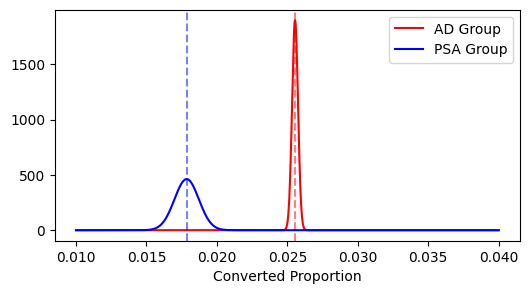

In [ ]:
# Standard error in each group
se_ad = np.sqrt(mean_ad * (1-mean_ad)) / np.sqrt(total_ad)
se_no_ad = np.sqrt(mean_no_ad * (1-mean_no_ad)) / np.sqrt(total_no_ad)

# Plot conversion rates
fig, ax = plt.subplots(figsize=(6,3))
x = np.linspace(0.01, 0.04, 1000)
yA = stats.norm(mean_ad, se_ad).pdf(x)
ax.plot(x, yA, c='red', label='AD Group')
ax.axvline(x=mean_ad, c='red', alpha=0.5, linestyle='--')
yB = stats.norm(mean_no_ad, se_no_ad).pdf(x)
ax.plot(x, yB, c='blue', label='PSA Group')
ax.axvline(x=mean_no_ad, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Proportion')
plt.legend()
plt.show()

In [ ]:
se_pooled = np.sqrt(mean_ad*(1-mean_ad)/total_ad + mean_no_ad*(1-mean_no_ad)/total_no_ad)
ci = (diff - Z_alpha*se_pooled, diff + Z_alpha*se_pooled)
print(f"Confidence interval: {ci[0]:.4f} to {ci[1]:.4f}")

Confidence interval: 0.0060 to 0.0094


In [ ]:
# This is the same as regression
t_results = stats.ttest_ind(df.loc[df["test_group"] == "ad", "converted"]*1,
                            df.loc[df["test_group"] == "psa", "converted"]*1)
print(f"t-statistic: {t_results.statistic:.4f} with p-value: {t_results.pvalue:.4f}")

t-statistic: 7.3704 with p-value: 0.0000


In [ ]:
# Welch's t-test
t_results = stats.ttest_ind(df.loc[df["test_group"] == "ad", "converted"]*1,
                            df.loc[df["test_group"] == "psa", "converted"]*1,
                            equal_var=False)
print(f"Welch's t-statistic: {t_results.statistic:.4f} with p-value: {t_results.pvalue:.4f}")

Welch's t-statistic: 8.6572 with p-value: 0.0000


**Conclusions:**

- Si el intervalo de confianza no contiene cero, podemos rechazar la hipótesis nula y concluir que los anuncios tuvieron un efecto en la tasa de conversión.

- Si realizamos el experimento muchas veces, esperaríamos que el intervalo de confianza contenga el efecto verdadero el 95% de las veces.

- Esto no es lo mismo que decir que estamos 95% seguros de que el efecto verdadero está contenido en el intervalo de confianza (para eso necesitarías un enfoque bayesiano).

- Significancia práctica: si los anuncios tuvieron un efecto, ¿qué tan grande fue? ¿Vale la pena el costo de la campaña para un efecto de una tasa de conversión de 0.5 a 1%?

**TO DO: Sanity Checks**

Verifique si las métricas invariantes son similares entre los grupos. Calcule el estadístico t y el valor p para cada métrica invariante y proporcione una conclusión.

In [ ]:
# Invariant metric: total_ads
t_results = stats.ttest_ind(df.loc[df["test_group"] == "ad", "total_ads"],
                            df.loc[df["test_group"] == "psa", "total_ads"])
print(f"t-statistic: {t_results.statistic:.4f} with p-value: {t_results.pvalue:.4f}")

t-statistic: 0.2139 with p-value: 0.8306


In [ ]:
# Invariant metric: most_ads_hour
t_results = stats.ttest_ind(df.loc[df["test_group"] == "ad", "most_ads_hour"],
                            df.loc[df["test_group"] == "psa", "most_ads_hour"])
print(f"t-statistic: {t_results.statistic:.4f} with p-value: {t_results.pvalue:.4f}")

t-statistic: 5.3147 with p-value: 0.0000


## Bootstrap

Si el tamaño de la muestra es pequeño, podemos usar el bootstrap para estimar el intervalo de confianza.

In [ ]:
# Bootstrap A/B testing
n = 100 # it should be 1 million
boot_diff = []

for _ in range(n):
    sample = df.sample(frac=1, replace=True)
    ad = sample.loc[sample.test_group == 'ad', 'converted'].mean()
    psa = sample.loc[sample.test_group == 'psa', 'converted'].mean()
    boot_diff.append(ad - psa)

ci = np.percentile(boot_diff, [alpha/2*100, (1-alpha/2)*100])
print(f"Bootstrap confidence interval: {ci[0]:.4f} to {ci[1]:.4f}")

Bootstrap confidence interval: 0.0063 to 0.0096


**TO DO: Sanity Checks with Bootstrap**

Verifique si las métricas invariantes son similares entre los grupos usando bootstrap. Calcule el intervalo de confianza para cada métrica invariante y proporcione una conclusión.

In [ ]:
# Bootstrap A/B testing: total_ads
n = 100
boot_diff = []

for _ in range(n):


ci = np.percentile(boot_diff, [alpha/2*100, (1-alpha/2)*100])
print(f"Bootstrap confidence interval: {ci[0]:.4f} to {ci[1]:.4f}")

In [ ]:
# Bootstrap A/B testing: most_ads_hour


## [Quantile A/B Testing](https://engineering.atspotify.com/2022/03/comparing-quantiles-at-scale-in-online-a-b-testing/)

Si nos importan más los extremos de la distribución, podemos usar pruebas A/B de cuantiles.

In [ ]:
import numpy.random as npr
npr.seed(42)

# Simulate daily use of Spotify
sample_size = 5000
n_boot_samples = 50000
daily_use_control = npr.normal(120, 60, sample_size).clip(0)
daily_use_treatment = npr.normal(140, 45, sample_size).clip(0)

# Plot the distribution of daily use
fig, ax = plt.subplots(figsize=(6,3))
ax.hist(daily_use_control, bins=50, alpha=0.5, label='Control')
ax.hist(daily_use_treatment, bins=50, alpha=0.5, label='Treatment')
plt.xlabel('Daily Use (Minutes)')
plt.legend()
plt.show()

In [ ]:
# Bootstrap A/B testing for Difference in Means

boot_diff = []

for _ in range(n_boot_samples):
    sample_control = npr.choice(daily_use_control, size=sample_size, replace=True)
    sample_treatment = npr.choice(daily_use_treatment, size=sample_size, replace=True)
    boot_diff.append(sample_treatment.mean() - sample_control.mean())

ci = np.percentile(boot_diff, [alpha/2*100, (1-alpha/2)*100])
print(f"The difference in means is {daily_use_treatment.mean() - daily_use_control.mean():.4f}")
print(f"Bootstrap confidence interval: {ci[0]:.4f} to {ci[1]:.4f}")

In [ ]:
# Bootstrap A/B testing for Difference in Quantiles
quantile = 0.8

outcome_control_sorted = np.sort(daily_use_control)
outcome_treatment_sorted = np.sort(daily_use_treatment)
boot_diff_distrib = (outcome_treatment_sorted[npr.binomial(sample_size+1, quantile, n_boot_samples)]
                     - outcome_control_sorted[npr.binomial(sample_size+1, quantile, n_boot_samples)])
boot_ci = np.quantile(boot_diff_distrib, [alpha/2 , 1-alpha/2])
q_diff = np.quantile(outcome_treatment_sorted, quantile) - np.quantile(outcome_control_sorted, quantile)

print(f"The difference-in-q{quantile*100:.0f} is {q_diff:.2f}.")
print(f"The bootstrap confidence interval is {boot_ci[0]:.2f} to {boot_ci[1]:.2f}.")

**TO DO: Light Users**

¿Hay un efecto para los usuarios que no usan Spotify con frecuencia? Calcule el intervalo de confianza bootstrap para el cuantil respectivo y proporcione una conclusión.

In [ ]:
# Bootstrap A/B testing for Difference in Quantiles




print(f"The difference-in-q{quantile*100:.0f} is {q_diff:.2f}.")
print(f"The bootstrap confidence interval is {boot_ci[0]:.2f} to {boot_ci[1]:.2f}.")